This notebook intends to show how to use the developed API to construct a `StableDiffusion` object and generate an image from a textual prompt.

---

We started noticing that, in the reference codebase, running any part of the stable diffusion model required the initialization and loading of the entire `LatentDiffusion` module, which loads the stable diffusion models' checkpoints.

The `LatentDiffusion` module is composed mainly by three submodules: `UNetModel`, `Autoencoder` and `CLIPTextEmbedder`. It makes sense to use these submodules individually, and we wanted to increase the pipeline modularity, in order for it to support individual runs. For instance, the `CLIPTextEmbedder` turns textual prompts into tensors in an embedding space. It makes perfect sense to embed a number of textual prompts, then run the rest of the pipeline over these embeddings. Heavier parts of the `LatentDiffusion` model, such as the UNet and the autoencoder aren't needed to embed the prompts. Hence the first goal was to add support for the individual usage of the submodules that 'made sense' to be used individually.

The second goal was to avoid downloads during runtime altogether, while minimizing usage of external libraries. These downloads were occurring mainly due to the `transformers` library, that was being used to load/download the `openai/clip-vit-large-patch14` model and construct the text embedder. 

The third goal was to add support to `.safetensors`. Since `torch` still doesn't support it natively, and the very process of saving and loading being different, that was quite troublesome. To begin with, with `safetensors` the serialization is only at tensors level, so you can only save/load dictionaries of tensors, which are in general weights or state dicts; with pickle, you can save the very Python object, so that when you load it *you already have an instance of it*. That's important because *you need an instance of the model you are trying to load weights into*. And if you don't have the code for the object (in general, the code for a `nn.Module` that instantiates a module with a state dict compatible with what you are loading into object), you won't be able to use `.safetensors`. And we didn't had the codes for the submodels the `CLIPTextEmbedder` has, since they were coming from `transformers` lib.

In [1]:
import os
import sys

base_directory = "../"
sys.path.insert(0, base_directory)
print(os.path.abspath(base_directory))

import json
import torch
import configparser
import safetensors
from stable_diffusion.utils.utils import get_device, to_pil, get_memory_status
from stable_diffusion.utils.utils import SectionManager as section
from stable_diffusion.constants import IODirectoryTree
from stable_diffusion.constants import TOKENIZER_PATH, TEXT_MODEL_PATH


/home/izzortsi/.cloned/kcg-ml-sd1p4


In [2]:
DEVICE = get_device()
config = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
config.read(os.path.join(base_directory, "config.ini"))
config['BASE']['BASE_DIRECTORY'] = base_directory

INFO: `device` given is `None`. Falling back to device: cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [3]:
pt = IODirectoryTree(base_io_directory_prefix = config["BASE"].get('base_io_directory_prefix'), base_directory=base_directory)
pt

IODirectoryTree:
                - ../
                -- model's root dir: ../input/model/
                --- stable diffusion model checkpoint: ../input/model/v1-5-pruned-emaonly.safetensors
                --- stable diffusion submodels dir: ../input/model/v1-5-pruned-emaonly
                ---- unet model: ../input/model/v1-5-pruned-emaonly/unet.safetensors
                ---- autoencoder model: ../input/model/v1-5-pruned-emaonly/autoencoder.safetensors
                ---- encoder model: ../input/model/v1-5-pruned-emaonly/encoder.safetensors
                ---- decoder model: ../input/model/v1-5-pruned-emaonly/decoder.safetensors
                ---- latent_diffusion model: ../input/model/v1-5-pruned-emaonly/latent_diffusion.safetensors
                --- clip models' root dir: ../input/model/clip
                ---- clip image encoder checkpoint path: ../input/model/clip/image_encoder.safetensors
                ---- clip text embedder checkpoint path: ../input/model/clip/t

In [4]:
pt.create_directory_tree_folders()

{'root_models_path': './input/model/',
 'checkpoint_path': './input/model/v1-5-pruned-emaonly.safetensors',
 'embedder_path': './input/model/clip/text_embedder.safetensors',
 'embedder_submodels_paths': {'tokenizer_path': './input/model/clip/text_embedder/tokenizer',
  'transformer_path': './input/model/clip/text_embedder/vit-large-patch14'},
 'image_encoder_path': './input/model/clip/image_encoder/clip_image_encoder.ckpt',
 'image_encoder_submodels_paths': {'image_processor_path': './input/model/clip/image_encoder/image_processor.ckpt',
  'clip_model_path': './input/model/clip/image_encoder/clip_model.ckpt'},
 'unet_path': './input/model/v1-5-pruned-emaonly/unet.safetensors',
 'autoencoder_path': './input/model/v1-5-pruned-emaonly/autoencoder.safetensors',
 'autoencoder_submodels_paths': {'encoder_path': './input/model/v1-5-pruned-emaonly/encoder.safetensors',
  'decoder_path': './input/model/v1-5-pruned-emaonly/decoder.safetensors'},
 'latent_diffusion_path': './input/model/v1-5-prun

We are using `transformers` for the CLIP models.

On a first run, since we don't have the required model on cache, the next cell would normally download the pretrained tokenizer from `openai/clip-vit-large-patch14` on Huggingface.

In [5]:
from transformers import CLIPTokenizer

# tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')

Instead, we have the tokenizer files (are very light) in our repo, so we load from it with:

In [6]:
tokenizer = CLIPTokenizer.from_pretrained(pt.tokenizer_path, local_files_only=True)

In [7]:
# this is how you save it
# sd_savepath = os.path.join(pt.sd_model_dir, "clip_")
# tokenizer.save_pretrained(sd_savepath+"tokenizer", safe_serialization=True)

Here again, if we didn't have the required configuration file on cache, the next cell would normally download the `CLIPTextModel` config file from `openai/clip-vit-large-patch14` on Huggingface. That is needed for us to initialize an empty `CLIPTextModel` object.

In [8]:
from transformers import CLIPTextConfig, CLIPTextModel

#fetch config file from huggingface and save it to the model folder
# config = CLIPTextConfig.from_pretrained("openai/clip-vit-large-patch14")
# config.save_pretrained(pt.text_model_path)
# config

We also have that config file in our repo, so we can load it from disk.

In [9]:
config = CLIPTextConfig.from_pretrained(pt.text_model_path, local_files_only=True)
# config = CLIPTextConfig.from_pretrained('../input/model/clip/text_embedder/text_model/config.json')
config

CLIPTextConfig {
  "_name_or_path": "openai/clip-vit-large-patch14",
  "architectures": [
    "CLIPTextModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "dropout": 0.0,
  "eos_token_id": 2,
  "hidden_act": "quick_gelu",
  "hidden_size": 768,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 77,
  "model_type": "clip_text_model",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "projection_dim": 768,
  "torch_dtype": "float32",
  "transformers_version": "4.29.2",
  "vocab_size": 49408
}

Then we can finally instantiate a `CLIPTextModel`:

In [10]:
text_model = CLIPTextModel(config)

In [11]:
get_memory_status()

Total: 12037 MiB
Free: 10942 MiB
Used: 1095 MiB


In [12]:
text_model.to(DEVICE)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [13]:
get_memory_status()

Total: 12037 MiB
Free: 10434 MiB
Used: 1603 MiB


In [20]:
text_model.save_pretrained(pt.text_model_path, safe_serialization=True)

In [15]:
# test load
# text_model = CLIPTextModel.from_pretrained(pt.text_model_path, local_files_only=True, use_safetensors=True).eval().to(DEVICE)

Now we finally can instantiate a text embedder without loading any weights.

In [16]:
from stable_diffusion.model.clip_text_embedder import CLIPTextEmbedder

In [17]:
text_embedder = CLIPTextEmbedder(pt, device=DEVICE, tokenizer = tokenizer, transformer=text_model)

INFO: Device given: cuda:0. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [18]:
text_embedder.to(text_embedder.device)

CLIPTextEmbedder(
  (transformer): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768,

Naturally, at this point we should be able to embed a prompt, albeit badly, because we started the CLIPTextModel with no weights, the configuration alone:

In [19]:
text_embedder('A great sword')

tensor([[[-0.2650,  0.6488, -1.1712,  ...,  1.4935, -1.5459,  1.2991],
         [-0.8438,  0.8581, -0.9448,  ...,  2.0467, -1.7545,  1.5763],
         [-0.9196,  0.3396, -0.9904,  ...,  1.4700, -1.4466,  1.3965],
         ...,
         [-0.1226,  0.0041, -1.1589,  ...,  1.3797, -0.9868,  0.4138],
         [-0.2664, -0.0522, -1.1904,  ...,  1.3329, -0.8600,  0.4082],
         [ 0.0207, -0.0549, -1.1523,  ...,  1.4867, -0.7942,  0.3525]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

If we haven't done the process of creating the submodels instances, we would have, instead:

In [21]:
not_text_embedder = CLIPTextEmbedder(pt, device=DEVICE, tokenizer = None, transformer= None)

INFO: Device given: cuda:0. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [22]:
not_text_embedder.to(not_text_embedder.device)

CLIPTextEmbedder()

And, obviously, our forward wouldn't work:

In [23]:
not_text_embedder('A great sword')

TypeError: 'NoneType' object is not callable

Let's redo the text embedder, but now loading the saved submodels.

In [24]:
text_embedder = CLIPTextEmbedder(pt, device=DEVICE, tokenizer = None, transformer= None)

INFO: Device given: cuda:0. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [25]:
# still empty
text_embedder

CLIPTextEmbedder()

In [26]:
text_embedder.load_submodels(tokenizer_path = pt.tokenizer_path, transformer_path = pt.text_model_path)

Tokenizer successfully loaded from : ../input/model/clip/text_embedder/tokenizer

CLIP text model successfully loaded from : ../input/model/clip/text_embedder/text_model



CLIPTextEmbedder(
  (transformer): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768,

In [26]:
# we could also save our submodels to disk for later use
# text_embedder.save_submodels(tokenizer_path=pt.tokenizer_path, text_model_path=pt.text_model_path)

Now we need to create an instance for two other submodules, `UNetModel` and `Autoencoder`. Those submodules should be easier to initialize since we have the `nn.Module` objects defined, and can avoid `transformers` entirely.

The `Autoencoder` is also composed of two submodules that are actually useful individually, `Encoder` and `Decoder`. Let's start instantiating it.

In [27]:
from stable_diffusion.utils.model import initialize_encoder
from stable_diffusion.model.vae import Encoder

In [28]:
def initialize_encoder(device = None, 
                        z_channels=4,
                        in_channels=3,
                        channels=128,
                        channel_multipliers=[1, 2, 4, 4],
                        n_resnet_blocks=2) -> Encoder:
    
    with section('encoder initialization'):
        device = get_device(device)
    # Initialize the encoder
        encoder = Encoder(z_channels=z_channels,
                        in_channels=in_channels,
                        channels=channels,
                        channel_multipliers=channel_multipliers,
                        n_resnet_blocks=n_resnet_blocks).to(device)
    return encoder

In [29]:
encoder = initialize_encoder(device=DEVICE)

Starting section: encoder initialization...
INFO: Device given: cuda:0. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Finished section: encoder initialization in 0.16 seconds



In [30]:
from stable_diffusion.utils.model import initialize_decoder
from stable_diffusion.model.vae import Decoder

In [31]:
def initialize_decoder(device = None, 
                        out_channels=3,
                        z_channels=4,
                        channels=128,
                        channel_multipliers=[1, 2, 4, 4],
                        n_resnet_blocks=2) -> Decoder:
    
    with section('decoder initialization'):
        device = get_device(device)
        decoder = Decoder(out_channels=out_channels,
                        z_channels=z_channels,
                        channels=channels,
                        channel_multipliers=channel_multipliers,
                        n_resnet_blocks=n_resnet_blocks).to(device)    
    return decoder

In [32]:
decoder = initialize_decoder(device=DEVICE)

Starting section: decoder initialization...
INFO: Device given: cuda:0. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Finished section: decoder initialization in 0.24 seconds



In [33]:
from stable_diffusion.utils.model import initialize_autoencoder
from stable_diffusion.model.vae import Autoencoder

In [34]:
def initialize_autoencoder(device = None, encoder = None, decoder = None, emb_channels = 4, z_channels = 4, force_submodels_init = False) -> Autoencoder:
    # Initialize the autoencoder
    
    with section(f'autoencoder initialization'):
        device = get_device(device)
        if force_submodels_init:
            if encoder is None:
                encoder = initialize_encoder(device=device, z_channels=z_channels)
            if decoder is None:
                decoder = initialize_decoder(device=device, z_channels=z_channels)
        
        autoencoder = Autoencoder(emb_channels=emb_channels,
                                    encoder=encoder,
                                    decoder=decoder,
                                    z_channels=z_channels).to(device)
    return autoencoder

In [35]:
autoencoder = initialize_autoencoder(device=DEVICE, encoder=encoder, decoder=decoder)

Starting section: autoencoder initialization...
INFO: Device given: cuda:0. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: `device` given is `None`. Falling back to device: cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Finished section: autoencoder initialization in 0.00 seconds



Okay, now we have an untrained autoencoder. Now we just need the UNet.

In [36]:
from stable_diffusion.model.unet import UNetModel
from stable_diffusion.utils.model import initialize_unet

In [37]:
def initialize_unet(device = None, 
                    in_channels=4,
                    out_channels=4,
                    channels=320,
                    attention_levels=[0, 1, 2],
                    n_res_blocks=2,
                    channel_multipliers=[1, 2, 4, 4],
                    n_heads=8,
                    tf_layers=1,
                    d_cond=768) -> UNetModel:

    # Initialize the U-Net
    device = get_device(device)
    with section('U-Net initialization'):
        unet_model = UNetModel(in_channels=in_channels,
                                out_channels=out_channels,
                                channels=channels,
                                attention_levels=attention_levels,
                                n_res_blocks=n_res_blocks,
                                channel_multipliers=channel_multipliers,
                                n_heads=n_heads,
                                tf_layers=tf_layers,
                                d_cond=d_cond).to(device)
            # unet_model.save()
            # torch.save(unet_model, UNET_PATH)
    return unet_model

In [38]:
unet_model = initialize_unet(device=DEVICE)

INFO: Device given: cuda:0. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Starting section: U-Net initialization...
Finished section: U-Net initialization in 3.74 seconds



In [39]:
get_memory_status()

Total: 12037 MiB
Free: 6147 MiB
Used: 5890 MiB


Now we need to build a model with the same structure that the checkpoint we are going to use (by default, `runwayml/stable-diffusion-v1-5`), so the weights get properly mapped. This model is called `LatentDiffusion`. We also have a `initialize_latent_diffusion` function, which I will omit since it's a bit longer than the others.

In [40]:
from stable_diffusion import LatentDiffusion
# from stable_diffusion.utils.model import initialize_latent_diffusion

In [41]:
with section('Latent Diffusion model initialization'):
    latent_diffusion = LatentDiffusion(linear_start=0.00085,
                            linear_end=0.0120,
                            n_steps=1000,
                            latent_scaling_factor=0.18215,
                            autoencoder=autoencoder,
                            clip_embedder=text_embedder,
                            unet_model=unet_model,
                            device=DEVICE)

Starting section: Latent Diffusion model initialization...
INFO: Device given: cuda:0. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Finished section: Latent Diffusion model initialization in 0.01 seconds



In [42]:
import safetensors

In [43]:
with section(f"stable diffusion checkpoint loading, from {pt.checkpoint_path}"):
    stable_diffusion_checkpoint = safetensors.torch.load_file(pt.checkpoint_path, device="cpu")

Starting section: stable diffusion checkpoint loading, from ../input/model/v1-5-pruned-emaonly.safetensors...
Finished section: stable diffusion checkpoint loading, from ../input/model/v1-5-pruned-emaonly.safetensors in 0.17 seconds



Push them weights into dat model, ya

In [44]:
with section('model state loading'):
    missing_keys, extra_keys = latent_diffusion.load_state_dict(stable_diffusion_checkpoint, strict=False)

Starting section: model state loading...
Finished section: model state loading in 0.53 seconds



It's common that some weights don't get mapped perfectly.

In [45]:
print(extra_keys)
print(len(extra_keys))
print(missing_keys)
print(len(missing_keys))

['alphas_cumprod', 'alphas_cumprod_prev', 'betas', 'log_one_minus_alphas_cumprod', 'model_ema.decay', 'model_ema.num_updates', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2', 'posterior_variance', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod']
14
['beta', 'alpha_bar']
2


But now we have a fully loaded latent diffusion model. To actually perform the 'stable diffusion', which is actually a kind of latent diffusion model, we need yet another class, the `StableDiffusion`. Roughly speaking, the `StableDiffusion` class uses the `LatentDiffusion` model in a specific way to denoise a random sample from the latent space. It uses a diffusion process for that, hence 'latent diffusion'. What defines this process, i.e, how to use the `LatentDiffusion` model to denoise a random sampling is a sampler. That's what gets added into the `StableDiffusion` class. Besides that, it provides a unified interface for inference.

In [46]:
from stable_diffusion import StableDiffusion

In [47]:
stable_diffusion = StableDiffusion(device=DEVICE, model = latent_diffusion, ddim_steps = 20)

INFO: Device given: cuda:0. Using device cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
LatentDiffusion model given. Initializing sampler.


In [48]:
prompt = 'A cat'

In [49]:
with section('sampling...'):
    image_tensor = stable_diffusion.generate_images(prompt = prompt, seed = 1)

Starting section: sampling......


Finished section: sampling... in 5.45 seconds



In [50]:
from stable_diffusion.utils.utils import to_pil

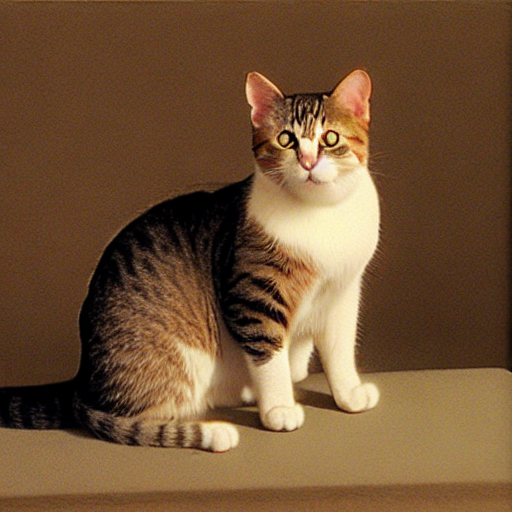

In [51]:
to_pil(image_tensor.squeeze())

Let's finish this notebook by saving all the relevant submodels to disk, with their weights loaded in. What we did: we broke the `v1-5...` checkpoint, a big file, into one checkpoint for each model, so now we can load the weights that were contained in the checkpoint more modularly. We will start part 2 by redoing the process of assembling a `StableDiffusion` instance by loading the checkpoints for the saved models, instead of loading the checkpoint for the `LatentDiffusion` model.

In [52]:
text_embedder.save_submodels(tokenizer_path = pt.tokenizer_path, transformer_path = pt.text_model_path)

transformer saved to:  ../input/model/clip/text_embedder/text_model
